In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.applications import ResNet152V2, EfficientNetB7, InceptionV3
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
from PIL import Image
import cv2

2024-12-02 21:04:34.748559: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-02 21:04:34.748682: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-02 21:04:34.916423: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Read Dataset**

In [2]:
# Read Train and Test Data Folders
train_path = "/kaggle/input/railway-track-fault-detection/Railway Track fault Detection Updated/Train"
test_path = "/kaggle/input/railway-track-fault-detection/Railway Track fault Detection Updated/Test"
valid_path = "/kaggle/input/railway-track-fault-detection/Railway Track fault Detection Updated/Validation"

In [3]:
#image classes
image_classes = os.listdir("/kaggle/input/railway-track-fault-detection/Railway Track fault Detection Updated/Validation")
image_classes

['Defective', 'Non defective']

# **Data Visualization**

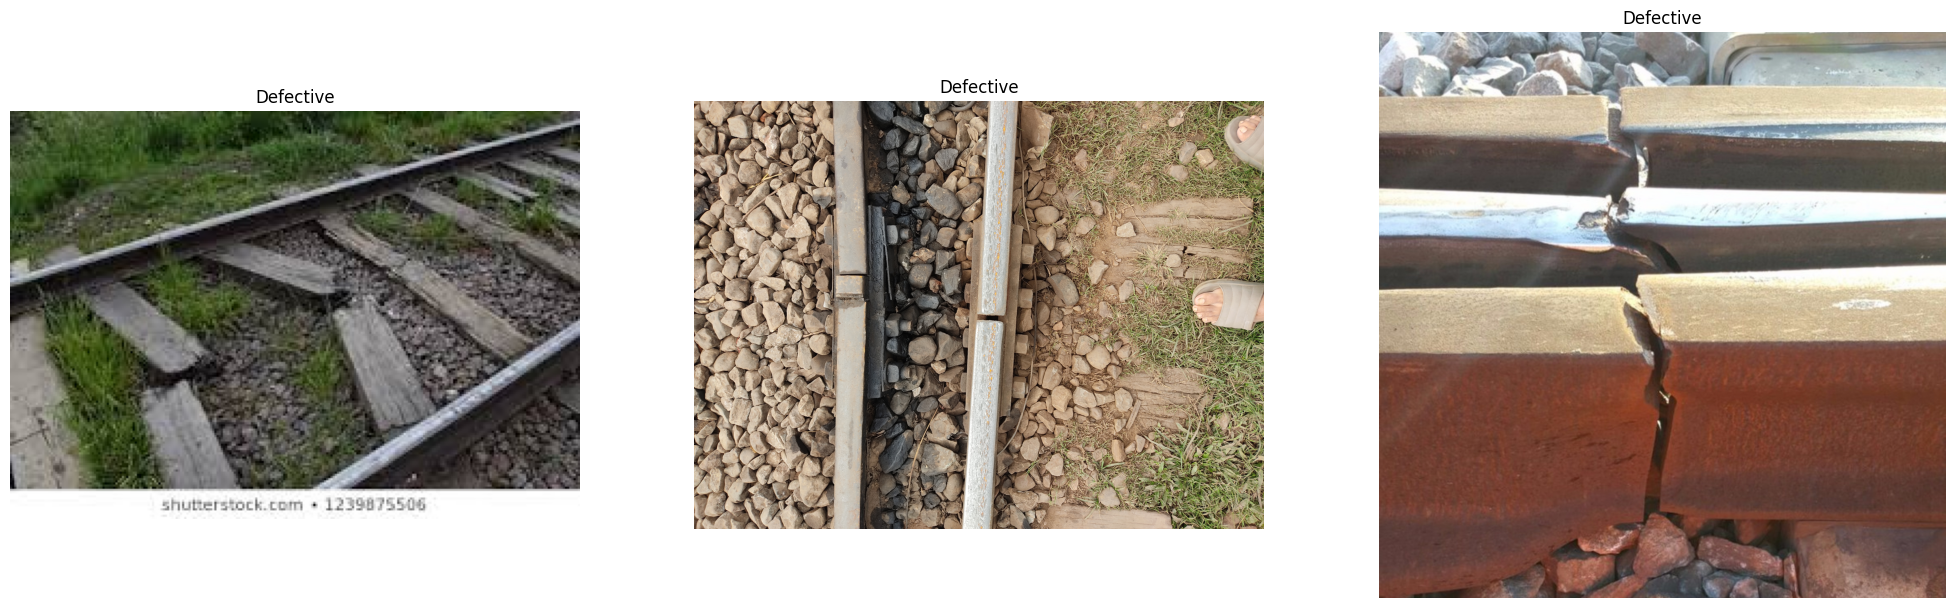

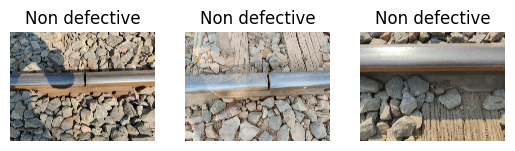

In [4]:
def plot_images(image_classes):
    plt.figure(figsize = (25, 25))
    
    for i, category in enumerate(image_classes):
        image_path = train_path + "/" + category
        image_in_folder = os.listdir(image_path)
        
        for j in range(3):
            omage = image_in_folder[j]
            omage_path = image_path + "/" + omage
        
            img = image.load_img(omage_path)
            img_array = image.img_to_array(img) / 255
            
            plt.subplot(3,3, j+1)
            plt.imshow(img_array)
            plt.title(category)
            plt.axis("off")
        plt.show()

plot_images(image_classes)

# **Data Augmentation**

In [5]:
image_generator = ImageDataGenerator(rescale=1./255)

In [6]:
train_data = image_generator.flow_from_directory(train_path,
                                                target_size = (448, 448),
                                                batch_size = 32,
                                                class_mode = "categorical")


Found 299 images belonging to 2 classes.


In [7]:
test_data = image_generator.flow_from_directory(test_path,
                                                target_size = (448, 448),
                                                batch_size = 1,
                                                class_mode = "categorical")

Found 22 images belonging to 2 classes.


In [8]:
valid_data = image_generator.flow_from_directory(valid_path,
                                                target_size = (448, 448),
                                                batch_size = 16,
                                                class_mode = "categorical")

Found 62 images belonging to 2 classes.


I used three different models for training and predicition
and did the same steps for all the three models

# **ResNet152V2 Model**

In [9]:
from tensorflow.keras.applications import ResNet152V2, EfficientNetB7, InceptionV3


model=ResNet152V2(input_shape=(448,448,3),weights='imagenet',include_top=False)
model.trainable = False # freeze the base model (for transfer learning)

x = model.output

## Add layers to cnn model

# INPUT AND HIDDEN LAYERS

# Convolutional Layer
x = Conv2D(filters=128, 
                 kernel_size = 5, 
                 padding = "same", 
                 activation = "relu"
         )(x)

# Pooling Layer
x = MaxPooling2D(pool_size = (2,2))(x)



# Convolutional Layer
x = Conv2D(filters= 64, 
                 kernel_size = 5, 
                 padding = "same", 
                 activation = "relu"
         )(x)

# Pooling Layer
x = MaxPooling2D()(x)



# CLASSIFICATION

# Flatten Layer
x = Flatten()(x)

# Fully Connected Layer
x = Dense(128, activation = "relu")(x)
x = Dense(128, activation = "relu")(x)

# Output Layer
y = Dense(2, activation = "softmax")(x)

# Freeze the base model layers (optional, for transfer learning)
for layer in model.layers:
    layer.trainable = False

model = Model(inputs=model.input, outputs=y)

234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


# **Model Summary**

In [10]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 448, 448,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 454, 454,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 224, 224,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 226, 226,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 112, 112,  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 112, 112,  │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 112, 112,  │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 112, 112,  │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 112, 112,  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 112, 112,  │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 114, 114,  │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 112, 112,  │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 112, 112,  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 112, 112,  │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 112, 112,  │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 112, 112,  │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 112, 112,  │          0 │ conv2_block1_0_c

 Total params: 65,180,866 (248.65 MB)

 Trainable params: 6,849,218 (26.13 MB)

 Non-trainable params: 58,331,648 (222.52 MB)

# **Model Compiling & Fitting**

In [11]:
model.compile(optimizer = "adam", 
             loss = "categorical_crossentropy",
             metrics = ["accuracy"])

In [12]:
# Define the Early Stopping Callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # The metric to monitor
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    verbose=1,           # Verbosity mode, 1 = progress bar
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

In [13]:
model_history = model.fit(train_data, 
                         epochs = 20,
                         validation_data = valid_data,
                         callbacks = [early_stopping])

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1733173612.549607     130 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/10 ━━━━━━━━━━━━━━━━━━━━ 201s 11s/step - accuracy: 0.5621 - loss: 1.8725 - val_accuracy: 0.7742 - val_loss: 0.5413
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.8499 - loss: 0.4136 - val_accuracy: 0.7097 - val_loss: 0.5993
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.9569 - loss: 0.1884 - val_accuracy: 0.7742 - val_loss: 0.5127
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.9825 - loss: 0.0579 - val_accuracy: 0.8387 - val_loss: 0.4526
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.9967 - loss: 0.0252 - val_accuracy: 0.7419 - val_loss: 0.6092
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.9970 - loss: 0.0126 - val_accuracy: 0.7258 - val_loss: 0.9480
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 1.0000 - loss: 0.0049 - val_accuracy: 0.7903 - val_loss: 0.7439
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 1.0000 - loss: 8.8807e-04 - val_accuracy: 0.7903 - val_loss: 0.66

# **Model Visualization**

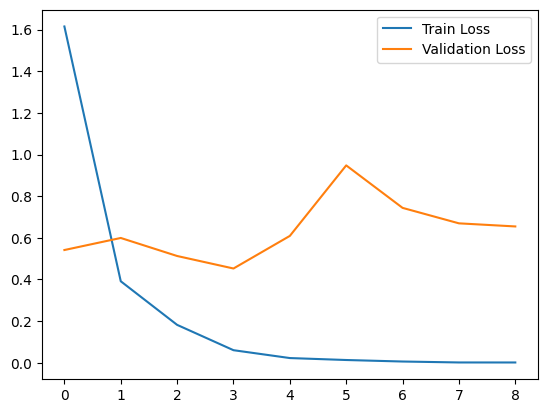

In [14]:
plt.plot(model_history.history["loss"], label = "Train Loss")
plt.plot(model_history.history["val_loss"], label = "Validation Loss")
plt.legend()
plt.show()

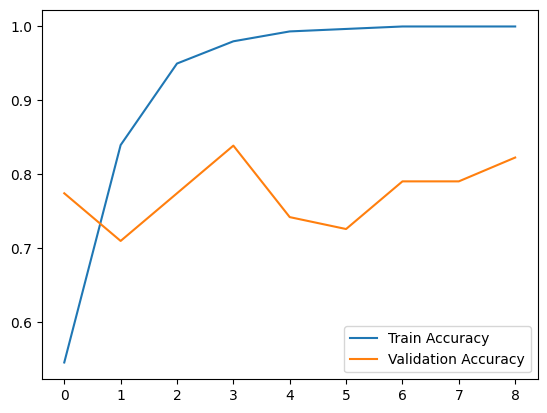

In [15]:
plt.plot(model_history.history["accuracy"], label = "Train Accuracy")
plt.plot(model_history.history["val_accuracy"], label = "Validation Accuracy")
plt.legend()
plt.show()

# **Model Evaluation**

In [16]:
model.evaluate(test_data)

22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 261ms/step - accuracy: 0.5983 - loss: 0.9131


[0.6395757794380188, 0.7272727489471436]

In [17]:
model.evaluate(train_data)

10/10 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 1.0000 - loss: 0.0195


[0.020381193608045578, 1.0]

# **Predicting New Images**

Downloading an image from the web and uploading it to kaggle

In [18]:
testing_images = ["/kaggle/input/new-images/Damaged_rail_on_Union_Pacific_tracks_in_Santa_Cruz.gk.jpg", 
                  "/kaggle/input/new-images/images.jpg", 
                  "/kaggle/input/new-images-2/Rail-defect-caused-by-manufacturing-process.png", 
                  "/kaggle/input/new-images-2/images (1).jpg"]

In [19]:
class_map = dict([value, key] for key, value in train_data.class_indices.items())
class_map

{0: 'Defective', 1: 'Non defective'}

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


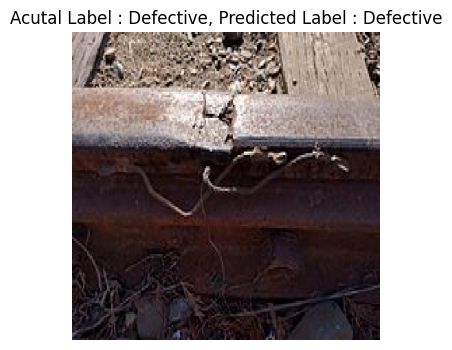

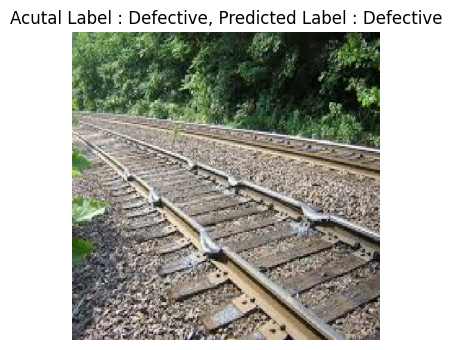

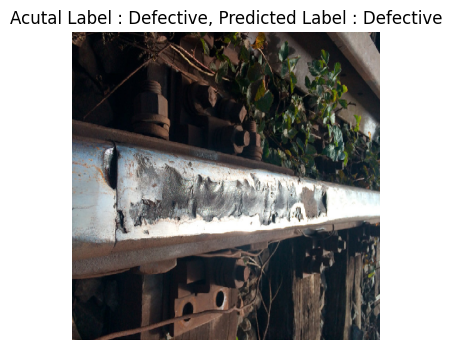

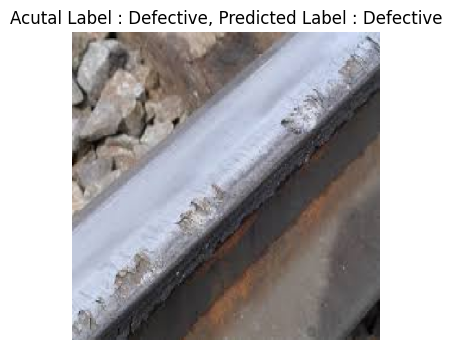

In [20]:
def prediction(testing_images, actual_label):
    
    for testing_image in testing_images:
        # Load & Preprocess the Image
        test_img = image.load_img(testing_image, target_size = (448,448))
        test_img_arr = image.img_to_array(test_img) / 255
        test_img_input = test_img_arr.reshape((1, test_img_arr.shape[0],
                                              test_img_arr.shape[1],
                                              test_img_arr.shape[2]))
    
        # Make Prediction
        predicted_class = np.argmax(model.predict(test_img_input))
        predicted_img = class_map[predicted_class]
    
        # Visulize the Image
        plt.figure(figsize = (4,4))
        plt.imshow(test_img_arr)
        plt.title("Acutal Label : {}, Predicted Label : {}".format(actual_label, 
                                                              predicted_img))
        plt.grid()
        plt.axis("off")
    
prediction(testing_images, actual_label = "Defective")

# **EfficientNetB7 Model**

In [21]:
from tensorflow.keras.applications import ResNet152V2, EfficientNetB7, InceptionV3


model=EfficientNetB7(input_shape=(448,448,3),weights='imagenet',include_top=False)
model.trainable = False # freeze the base model (for transfer learning)

x = model.output

## Add layers to cnn model

# INPUT AND HIDDEN LAYERS

# Convolutional Layer
x = Conv2D(filters=128, 
                 kernel_size = 5, 
                 padding = "same", 
                 activation = "relu"
         )(x)

# Pooling Layer
x = MaxPooling2D(pool_size = (2,2))(x)



# Convolutional Layer
x = Conv2D(filters= 64, 
                 kernel_size = 5, 
                 padding = "same", 
                 activation = "relu"
         )(x)

# Pooling Layer
x = MaxPooling2D()(x)



# CLASSIFICATION

# Flatten Layer
x = Flatten()(x)

# Fully Connected Layer
x = Dense(128, activation = "relu")(x)
x = Dense(128, activation = "relu")(x)

# Output Layer
y = Dense(2, activation = "softmax")(x)

# Freeze the base model layers (optional, for transfer learning)
for layer in model.layers:
    layer.trainable = False

model = Model(inputs=model.input, outputs=y)

258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


# **Model Summary**

In [22]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 448, 448,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 448, 448,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 448, 448,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 448, 448,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 449, 449,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 224, 224,  │      1,728 │ stem_conv_pad[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 224, 224,  │        256 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 224, 224,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 224, 224,  │        576 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 224, 224,  │        256 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 224, 224,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 64)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 64)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 16)  │      1,040 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 64)  │      1,088 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 224, 224,  │          0 │ block1a_activati… │
│ (Multiply)          │ 64)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 224, 224,  │      2,048 │ block1a_se_excit

 Total params: 72,585,305 (276.89 MB)

 Trainable params: 8,487,618 (32.38 MB)

 Non-trainable params: 64,097,687 (244.51 MB)

# **Model Compilling & Fitting**

In [23]:
model.compile(optimizer = "adam", 
             loss = "categorical_crossentropy",
             metrics = ["accuracy"])

In [24]:
# Define the Early Stopping Callback
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=5,          
    verbose=1,           
    restore_best_weights=True  
)

model_history = model.fit(train_data, 
                         epochs = 20,
                         validation_data = valid_data,
                         callbacks = [early_stopping])

Epoch 1/20


2024-12-02 21:18:19.716568: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k5=1,k6=0,k7=1,k10=1} for conv (f32[32,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,224,224]{3,2,1,0}, f32[64,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=64, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-12-02 21:18:19.970753: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.254369784s
Trying algorithm eng12{k5=1,k6=0,k7=1,k10=1} for conv (f32[32,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,224,224]{3,2,1,0}, f32[64,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=64, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyr

10/10 ━━━━━━━━━━━━━━━━━━━━ 409s 23s/step - accuracy: 0.5054 - loss: 9.1457 - val_accuracy: 0.5000 - val_loss: 8.8993
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.5490 - loss: 6.0567 - val_accuracy: 0.5000 - val_loss: 9.1355
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.4743 - loss: 3.5305 - val_accuracy: 0.5000 - val_loss: 2.1287
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.5295 - loss: 1.6054 - val_accuracy: 0.5000 - val_loss: 3.2231
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.5066 - loss: 2.3358 - val_accuracy: 0.5000 - val_loss: 0.8045
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.5446 - loss: 0.8361 - val_accuracy: 0.5000 - val_loss: 0.8062
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.5013 - loss: 1.1755 - val_accuracy: 0.5000 - val_loss: 3.4148
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - accuracy: 0.5027 - loss: 2.1809 - val_accuracy: 0.5000 - val_loss: 1.5283
E

# **Model Visualization**

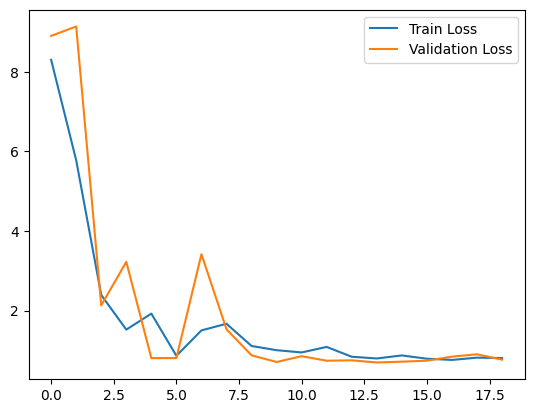

In [25]:
plt.plot(model_history.history["loss"], label = "Train Loss")
plt.plot(model_history.history["val_loss"], label = "Validation Loss")
plt.legend()
plt.show()

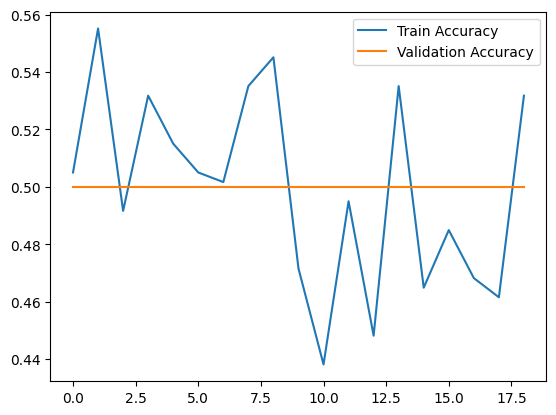

In [26]:
plt.plot(model_history.history["accuracy"], label = "Train Accuracy")
plt.plot(model_history.history["val_accuracy"], label = "Validation Accuracy")
plt.legend()
plt.show()

# **Model Evaluation**

In [27]:
model.evaluate(test_data)

22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - accuracy: 0.4010 - loss: 0.7067


[0.6949938535690308, 0.5]

In [28]:
model.evaluate(train_data)

10/10 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step - accuracy: 0.4954 - loss: 0.6952


[0.6946074366569519, 0.49832776188850403]

# **Prediciting New Images**

1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


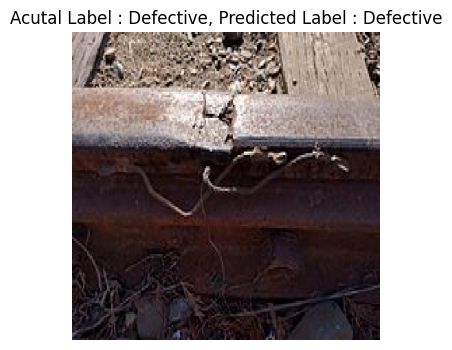

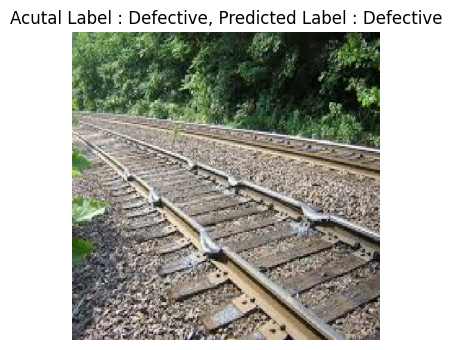

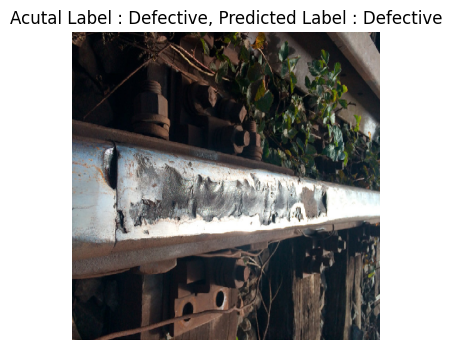

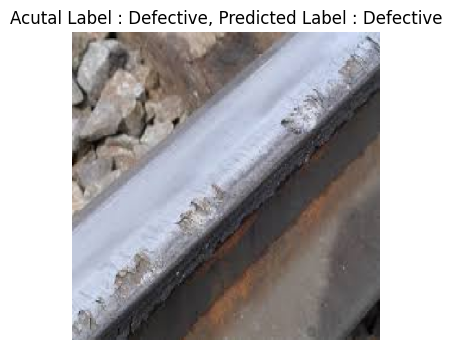

In [29]:
def prediction(testing_images, actual_label):
    
    for testing_image in testing_images:
        # Load & Preprocess the Image
        test_img = image.load_img(testing_image, target_size = (448,448))
        test_img_arr = image.img_to_array(test_img) / 255
        test_img_input = test_img_arr.reshape((1, test_img_arr.shape[0],
                                              test_img_arr.shape[1],
                                              test_img_arr.shape[2]))
    
        # Make Prediction
        predicted_class = np.argmax(model.predict(test_img_input))
        predicted_img = class_map[predicted_class]
    
        # Visulize the Image
        plt.figure(figsize = (4,4))
        plt.imshow(test_img_arr)
        plt.title("Acutal Label : {}, Predicted Label : {}".format(actual_label, 
                                                              predicted_img))
        plt.grid()
        plt.axis("off")
    
prediction(testing_images, actual_label = "Defective")

# **InceptionV3 Model**

In [30]:
from tensorflow.keras.applications import ResNet152V2, EfficientNetB7, InceptionV3


model=InceptionV3(input_shape=(448,448,3),weights='imagenet',include_top=False)
model.trainable = False # freeze the base model (for transfer learning)

x = model.output

## Add layers to cnn model

# INPUT AND HIDDEN LAYERS

# Convolutional Layer
x = Conv2D(filters=128, 
                 kernel_size = 5, 
                 padding = "same", 
                 activation = "relu"
         )(x)

# Pooling Layer
x = MaxPooling2D(pool_size = (2,2))(x)



# Convolutional Layer
x = Conv2D(filters= 64, 
                 kernel_size = 5, 
                 padding = "same", 
                 activation = "relu"
         )(x)

# Pooling Layer
x = MaxPooling2D()(x)



# CLASSIFICATION

# Flatten Layer
x = Flatten()(x)

# Fully Connected Layer
x = Dense(128, activation = "relu")(x)
x = Dense(128, activation = "relu")(x)

# Output Layer
y = Dense(2, activation = "softmax")(x)

# Freeze the base model layers (optional, for transfer learning)
for layer in model.layers:
    layer.trainable = False

model = Model(inputs=model.input, outputs=y)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# **Model Summary**

In [31]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 448, 448,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 223, 223,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 223, 223,  │         96 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 223, 223,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 221, 221,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 221, 221,  │         96 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 221, 221,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 221, 221,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 221, 221,  │        192 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 221, 221,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 110, 110,  │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 110, 110,  │      5,120 │ max_pooling2d_7[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 110, 110,  │        240 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 110, 110,  │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 108, 108,  │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 108, 108,  │        576 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 108, 108,  │          0 │ batch_normalizat

 Total params: 28,652,002 (109.30 MB)

 Trainable params: 6,849,218 (26.13 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

# **Model Compilling & Fitting**

In [32]:
model.compile(optimizer = "adam", 
             loss = "categorical_crossentropy",
             metrics = ["accuracy"])

In [33]:
# Define the Early Stopping Callback
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=5,          
    verbose=1,           
    restore_best_weights=True  
)

In [34]:
model_history = model.fit(train_data, 
                         epochs = 20,
                         validation_data = valid_data,
                         callbacks = [early_stopping])

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 169s 10s/step - accuracy: 0.4956 - loss: 2.2621 - val_accuracy: 0.6613 - val_loss: 0.6470
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.6333 - loss: 0.6807 - val_accuracy: 0.7258 - val_loss: 0.5605
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.8973 - loss: 0.2873 - val_accuracy: 0.7258 - val_loss: 0.4663
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.9117 - loss: 0.2019 - val_accuracy: 0.7419 - val_loss: 0.4620
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9726 - loss: 0.0936 - val_accuracy: 0.7419 - val_loss: 0.4994
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9800 - loss: 0.0469 - val_accuracy: 0.7097 - val_loss: 0.4924
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.9891 - loss: 0.0513 - val_accuracy: 0.7097 - val_loss: 0.7488
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 1.0000 - loss: 0.0065 - val_accuracy: 0.7097 - val_los

# **Model Visualization**

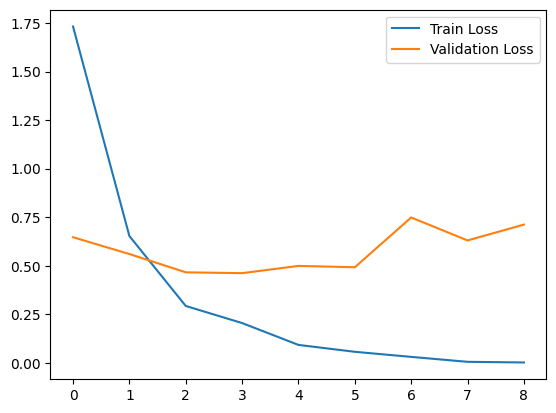

In [35]:
plt.plot(model_history.history["loss"], label = "Train Loss")
plt.plot(model_history.history["val_loss"], label = "Validation Loss")
plt.legend()
plt.show()

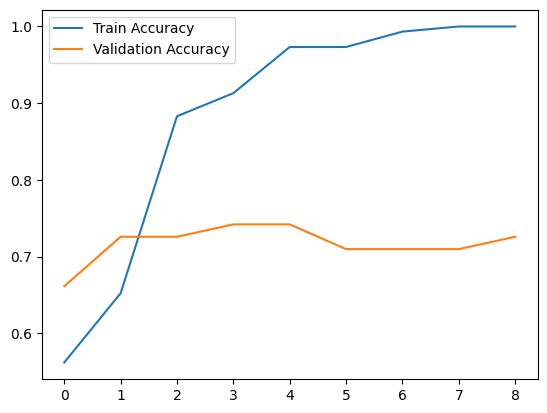

In [36]:
plt.plot(model_history.history["accuracy"], label = "Train Accuracy")
plt.plot(model_history.history["val_accuracy"], label = "Validation Accuracy")
plt.legend()
plt.show()

# **Model Evaluation**

In [37]:
model.evaluate(test_data)

22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - accuracy: 0.7912 - loss: 0.3292


[0.3513745963573456, 0.7727272510528564]

In [38]:
#InceptionV3 Model
model.evaluate(train_data)

10/10 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.9956 - loss: 0.0537


[0.05853425711393356, 0.9933110475540161]

# **Predicting New Images**

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


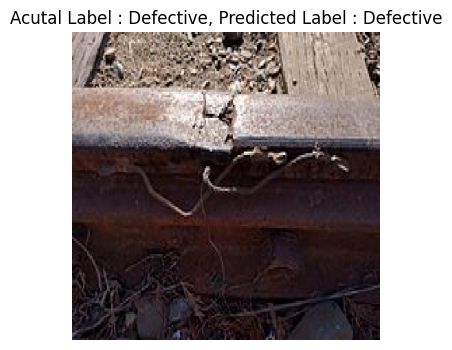

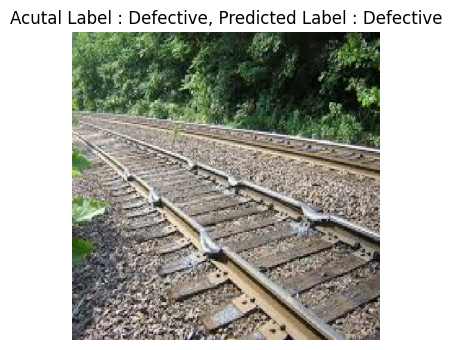

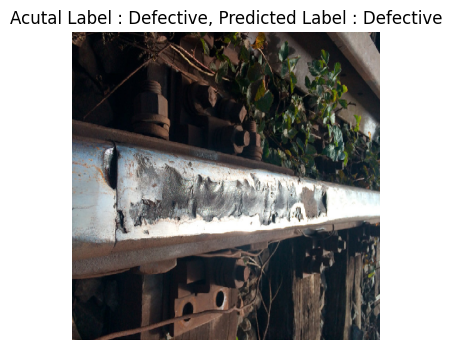

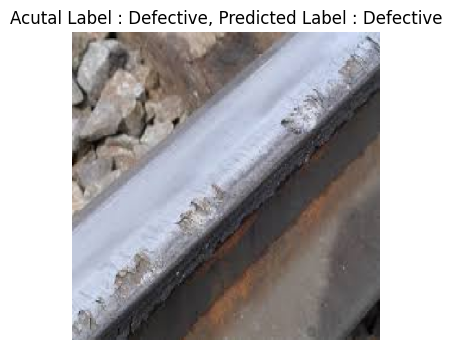

In [39]:
def prediction(testing_images, actual_label):
    
    for testing_image in testing_images:
        # Load & Preprocess the Image
        test_img = image.load_img(testing_image, target_size = (448,448))
        test_img_arr = image.img_to_array(test_img) / 255
        test_img_input = test_img_arr.reshape((1, test_img_arr.shape[0],
                                              test_img_arr.shape[1],
                                              test_img_arr.shape[2]))
    
        # Make Prediction
        predicted_class = np.argmax(model.predict(test_img_input))
        predicted_img = class_map[predicted_class]
    
        # Visulize the Image
        plt.figure(figsize = (4,4))
        plt.imshow(test_img_arr)
        plt.title("Acutal Label : {}, Predicted Label : {}".format(actual_label, 
                                                              predicted_img))
        plt.grid()
        plt.axis("off")
    
prediction(testing_images, actual_label = "Defective")

in the end the best model was the ResNet model and the worst was the EffientNet with Inception falling in the middle